In [16]:
import os
import numpy as np
import h5py
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json
import csv
import cv2


from datetime import datetime
from tqdm import tqdm
from PIL import Image


# Scikit-learn imports
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, top_k_accuracy_score, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from torchvision import transforms

In [17]:
species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

In [18]:
MODEL_SAVE_DIR = 'saved_models/full_image_model'
RESULT_DIR = 'images'  
DATA_DIR = "full_image_dataset"
AUGMENTED_DATA_DIR = "augmented_dataset"
DATASET = 'dataset_20250524.h5'
BATCH_SIZE = [32]
N_SPLITS = 5                            
NUM_EPOCHS = 25
NUM_CLASSES = len(species)

In [19]:
def openH5File(filepath, fold_idx, include_test=False):
    file = h5py.File(filepath, 'r')
    datasets = {}

    if fold_idx is not None:
        try:
            fold_group = file[f'cross_validation/fold_{fold_idx}']
            datasets['X_train'] = fold_group['X_train'][:]  # Load into memory
            datasets['y_train'] = fold_group['y_train'][:]
            datasets['X_val'] = fold_group['X_val'][:]
            datasets['y_val'] = fold_group['y_val'][:]
        except KeyError:
            file.close()
            raise ValueError(f"Fold {fold_idx} not found")
    else:
        datasets['X_train'] = file['train']['X_train'][:]
        datasets['y_train'] = file['train']['y_train'][:]
        datasets['X_val'] = file['val']['X_val'][:]
        datasets['y_val'] = file['val']['y_val'][:]

    if include_test:
        datasets['X_test'] = file['test']['X_test'][:]
        datasets['y_test'] = file['test']['y_test'][:]

    file.close()
    return datasets

def createDataloaders(X, y, batch_size, shuffle=False):
    if X.ndim == 4 and X.shape[-1] in {1, 3}:  # NHWC → NCHW
        X = np.transpose(X, (0, 3, 1, 2))

    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).long()
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size, shuffle, num_workers=4, pin_memory=True, persistent_workers=True)

def getDataloaders(filepath, fold_idx, batch_size, include_test=False):
    dataset = openH5File(filepath, fold_idx, include_test)
    train_loader, val_loader, test_loader = None, None, None

    if fold_idx is not None:
        # Cross-validation mode (train/val only)
        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size, shuffle=True)
        val_loader = createDataloaders(dataset['X_val'], dataset['y_val'], batch_size)
    else:
        # Full dataset mode (train/val/test)
        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size, shuffle=True)
        val_loader = createDataloaders(dataset['X_val'], dataset['y_val'], batch_size)
        if include_test:
            test_loader = createDataloaders(dataset['X_test'], dataset['y_test'], batch_size)
    return train_loader, val_loader, test_loader


In [20]:
def getModel(name, nClasses, dropout_rate=0):
    if name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
        target_layer = "features.8"
    elif name == 'efficientnet_V2':
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
        target_layer = "features.7"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(DEVICE), target_layer

def getOptimizer(model, params):
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    return optimizer

In [21]:
def trainModel(model, train_loader, val_loader, params, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = getOptimizer(model, params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) if params['scheduler'] else None

    best_f1 = 0
    THRESHOLD = 5
    improvementCounter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['val_f1'].append(val_f1)

        if scheduler:
            scheduler.step(val_loss)

        if val_f1 > best_f1:
            best_f1 = val_f1
            improvementCounter = 0
        else:
            improvementCounter += 1
            if improvementCounter >= THRESHOLD:
                break

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    return history, best_f1


In [22]:

def preprocessImage(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0) 
    return img

def getClassLabel(preds):
    _, class_idx = torch.max(preds, 1)
    return class_idx.item()

def getConvLayer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    raise ValueError(f"Layer {conv_layer_name} not found in model.")

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1-alpha, 0)
    return superimposed_img

def computeGradCam(model, img_tensor, class_idx, conv_layer_name):
    conv_layer_name = getConvLayer(model, conv_layer_name)

    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
    
    hook = conv_layer_name.register_forward_hook(forward_hook)

    img_tensor.requires_grad_(True)
    preds = model(img_tensor)
    loss = preds[:, class_idx]
    model.zero_grad()
    loss.backward()

    grads = img_tensor.grad.cpu().numpy()
    pooled_grads = np.mean(grads, axis=(0, 2, 3))

    hook.remove()

    activations = activations.detach().cpu().numpy()[0]
    for i in range(len(pooled_grads)):
        activations[i, :] *= pooled_grads[i]
    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def genGRADCAM(model, target_layer, test_loader, species_list):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    cam_results = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        for i in range(inputs.size(0)):
            class_idx = labels[i].item()
            img_tensor = inputs[i].unsqueeze(0)

            original_img_path_jpg = f"{DATA_DIR}/{species_list[class_idx]}/{species_list[class_idx]}_{i}.jpg"
            original_img_path_jpeg = f"{DATA_DIR}/{species_list[class_idx]}/{species_list[class_idx]}_{i}.jpeg"

            if os.path.exists(original_img_path_jpg):
                original_img_path = original_img_path_jpg
            elif os.path.exists(original_img_path_jpeg):
                original_img_path = original_img_path_jpeg
            original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            heatmap = computeGradCam(model, img_tensor, class_idx, target_layer)
            output_img = overlay_heatmap(original_img_path, heatmap)

            cam_results.append({
                'class_name': species_list[class_idx],
                'image': output_img[..., ::-1],  # BGR to RGB
                'original': original_img_rgb  
            })

            # Just one per class (optional early stop)
            if len(cam_results) >= len(species_list):
                return cam_results

    return cam_results


def saveGRADCAM(gradcam_results, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for result in gradcam_results:
        filename = f"gradcam_{result['class_name']}.png"
        image = result['image']
        if isinstance(image, np.ndarray):
            image = Image.fromarray((image * 255).astype(np.uint8)) if image.max() <= 1.0 else Image.fromarray(image)
        image.save(os.path.join(save_dir, filename))


def plotGRADCAM(gradcam_results, save_path):
    cols = NUM_CLASSES
    rows = 2 

    plt.figure(figsize=(5 * cols, 5 * rows))
    
    for i, result in enumerate(gradcam_results):
        # Original image (first row)
        plt.subplot(rows, cols, i + 1) 
        plt.imshow(result['original'])
        plt.title(f"{result['class_name']}")
        plt.axis('off')

        # Grad-CAM image (second row)
        plt.subplot(rows, cols, cols + i + 1)
        plt.imshow(result['image'])
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


def plotting(history, cm, metrics_dict, species, cam_images=None):
    # Plot training and evaluation graphs
    grad_path = os.path.join(MODEL_SAVE_DIR, RESULT_DIR, f"gradcams_{datetime.now().strftime('%Y%m%d')}.png")
    fig1 = plt.figure(figsize=(24, 8))

    # Training history
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Confusion matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=species, yticklabels=species)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Precision-recall
    plt.subplot(1, 3, 3)
    plt.plot(metrics_dict['recall'], metrics_dict['precision'], lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (AUPRC: {metrics_dict["macro_auprc"]:.4f})')

    plt.tight_layout()
    plot_path_graphs = os.path.join(MODEL_SAVE_DIR, RESULT_DIR, f"training_graphs_{datetime.now().strftime('%Y%m%d')}.png")
    plt.savefig(plot_path_graphs, dpi=300)
    plt.close(fig1)

    # Plot Grad-CAMs
    if cam_images:
        plotGRADCAM(cam_images, grad_path)


In [23]:
def gridSearch(filepath, n_splits, hyperparams):
    results_log = {
        "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S"),
        "total_combinations": len(list(itertools.product(*hyperparams.values()))),
        "best_f1": 0,
        "best_params": None,
        "all_results": []
    }

    # Generate all possible hyperparameter combinations
    param_combinations = [dict(zip(hyperparams.keys(), v)) 
                         for v in itertools.product(*hyperparams.values())]
    print(f"\nBeginning GridSearch with {len(param_combinations)} combinations...")
    
    for params in tqdm(param_combinations):
        #torch.cuda.reset_peak_memory_stats()
        print("\n" + "="*50)
        print(f"Testing combination: {params}")
        fold_f1_scores = []
        fold_acc_scores = []
        start_time = time.time()
        memory_tracker = []
        
        # Cross-validation loop
        for fold_idx in range(1, n_splits+1):
            torch.cuda.empty_cache()
            gc.collect()
            
            train_loader, val_loader, _ = getDataloaders(filepath, fold_idx, params['batch_size'], False)
            model, _ = getModel(params['model_name'], NUM_CLASSES, params.get('dropout_rate', 0))
            history, fold_f1 = trainModel(model, train_loader, val_loader, params)
            print(f"Fold {fold_idx} Best F1 Score: {fold_f1:.4f}")
            fold_f1_scores.append(fold_f1)
            fold_acc_scores.append(history['val_acc'][-1].item())
            memory_tracker.append(torch.cuda.max_memory_allocated()/1e9)

            # Clean up
            del model, train_loader, val_loader
            torch.cuda.empty_cache()
        
        # Calculate average F1 across folds
        avg_f1 = np.mean(fold_f1_scores)
        std_f1 = np.std(fold_f1_scores)
        avg_acc = np.mean(fold_acc_scores)
        std_acc = np.std(fold_acc_scores)
        time_taken = time.time() - start_time
        avg_memory = np.mean(memory_tracker)

        # Record this combination's results
        result_entry = {
            "params": params,
            "avg_f1": avg_f1,
            "std_f1": std_f1,
            "mean_acc": avg_acc,
            "std_acc": std_acc,
            "f1_scores": fold_f1_scores,
            "acc_scores": fold_acc_scores,
            "memory_used_GB": avg_memory,
            "time_taken": time_taken
        }
        results_log["all_results"].append(result_entry)
        
        # Update best parameters if improved
        if avg_f1 > results_log["best_f1"]:
            results_log["best_f1"] = avg_f1
            results_log["best_params"] = params
            print(f"New best parameters found with F1: {avg_f1:.4f}")

    # Finalize results        
    print("\nGridSearch completed!")
    torch.save(results_log["best_params"], os.path.join(MODEL_SAVE_DIR, f'gridsearch_setup1_{datetime.now().strftime("%Y%m%d")}.pth'))

    # Save JSON log
    json_path = os.path.join(MODEL_SAVE_DIR, f"gridsearch_results_{datetime.now().strftime("%Y%m%d")}.json")
    with open(json_path, 'w') as f:
        json.dump(results_log, f, indent=4)

    # Save CSV results
    csv_path = os.path.join(MODEL_SAVE_DIR, f"gridsearch_results_{datetime.now().strftime("%Y%m%d")}.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        header = ["params", "avg_f1", "std_f1", "mean_acc", "std_acc", "f1_scores", "acc_scores", "memory_used_GB", "time_taken"]
        writer.writerow(header)
        for res in results_log["all_results"]:
            writer.writerow([
                str(res["params"]), res["avg_f1"], res["std_f1"],
                res["mean_acc"], res["std_acc"],
                res["f1_scores"], res["acc_scores"],
                res["memory_used_GB"], res["time_taken"]
            ])

def bestTrainModel(filepath, best_params):
    model, target_layer = getModel(best_params['model_name'], nClasses=NUM_CLASSES, dropout_rate=best_params['dropout_rate'])
    train_loader, val_loader, test_loader = getDataloaders(filepath, None, best_params['batch_size'], True)
    history, _ = trainModel(model, train_loader, test_loader, best_params)

    # Generate Grad-CAMs
    cam_images = genGRADCAM(model, target_layer, test_loader, species)
    saveGRADCAM(cam_images, os.path.join(MODEL_SAVE_DIR, RESULT_DIR))

    # Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    criterion = nn.CrossEntropyLoss()
    test_loss, total_samples = 0.0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    labels_range = list(range(NUM_CLASSES))

    cm = confusion_matrix(all_labels, all_preds)
    binarized_labels = label_binarize(all_labels, classes=labels_range)
    precision, recall, _ = precision_recall_curve(binarized_labels[:, 0], all_probs[:, 0])

    metrics = {
        'test_loss': float(test_loss / total_samples),
        'top1_accuracy': float(accuracy_score(all_labels, all_preds)),
        'top3_accuracy': float(top_k_accuracy_score(all_labels, all_probs, k=3, labels=labels_range)),
        'f1_score': float(f1_score(all_labels, all_preds, average='weighted')),
        'confusion_matrix': cm.tolist(), 
        'macro_auprc': float(roc_auc_score(binarized_labels, all_probs, average='macro', multi_class='ovr')),
        'precision': precision.tolist(), 
        'recall': recall.tolist(),      
    }

    # Save model state dict and metadata
    final_model_path = os.path.join(MODEL_SAVE_DIR, f"final_model_{datetime.now().strftime("%Y%m%d")}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_name': best_params['model_name'],
        'target_layer': target_layer,
        'dropout_rate': best_params['dropout_rate'],
        'num_classes': NUM_CLASSES,
        'class_names': species,
        'metrics': metrics,
        'training_history': history
    }, final_model_path)
    
    # Save confusion matrix separately as numpy file
    np.save(os.path.join(MODEL_SAVE_DIR, f"confusion_matrix_{datetime.now().strftime('%Y%m%d')}.npy"), cm)
    
    # Now this will work:
    with open(os.path.join(MODEL_SAVE_DIR, f'final_metrics_{datetime.now().strftime("%Y%m%d")}.json'), 'w') as f:
        json.dump(metrics, f, indent=2)

    
    return model, history, metrics, cam_images 

In [24]:
# Main execution
# 1. Perform hyperparameter search
params = {
    'model_name': ['efficientnet_b0', 'efficientnet_V2'],
    'learning_rate': [0.0005, 0.0001],
    'batch_size': BATCH_SIZE,
    'weight_decay': [0.0001, 0],
    'optimizer': ['adamw'],
    'scheduler': [True],
    'dropout_rate': [0, 0.2]
}

# Ensure directories exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(MODEL_SAVE_DIR, RESULT_DIR), exist_ok=True)

#gridSearch(f"{DATA_DIR}/{DATASET}", N_SPLITS, params)

In [25]:
BEST_PARAMS = 'gridsearch_setup1_20250524.pth'
best_params = torch.load(os.path.join(MODEL_SAVE_DIR, BEST_PARAMS))
best_model, best_history, best_metrics, best_camImages = bestTrainModel(f"{DATA_DIR}/{DATASET}", best_params)
speciesModel = best_model.species if hasattr(best_model, 'species') else species

#Generate confusion matrix
cm = best_metrics['confusion_matrix']
        
#Plot results
plotting(
    history=best_history,
    cm=cm,
    metrics_dict=best_metrics,
    species=speciesModel,
    cam_images=best_camImages
)

KeyboardInterrupt: 

In [ ]:
print(f"Val loss : {best_history['val_loss']}")
print(f"Val_acc: {best_history['val_acc']}")
print(f"Val_f1: {best_history['val_f1']}")

Val loss : [0.8742513045502867, 0.7012811033139937, 0.7212759966315104, 0.7970741464708403, 0.8279502694961154, 0.8646587393763574, 0.8274360496788102, 0.8183843430180642, 0.8150791261266047, 0.8218258014221885, 0.8149495444837788, 0.8125750292299732, 0.8230148274206657, 0.8131516554116962, 0.8151403125545011, 0.8277826054874879, 0.8201573608015618, 0.807279238324797]
Val_acc: [tensor(0.7128, device='cuda:0', dtype=torch.float64), tensor(0.7725, device='cuda:0', dtype=torch.float64), tensor(0.7735, device='cuda:0', dtype=torch.float64), tensor(0.7776, device='cuda:0', dtype=torch.float64), tensor(0.7806, device='cuda:0', dtype=torch.float64), tensor(0.7755, device='cuda:0', dtype=torch.float64), tensor(0.7887, device='cuda:0', dtype=torch.float64), tensor(0.7958, device='cuda:0', dtype=torch.float64), tensor(0.7998, device='cuda:0', dtype=torch.float64), tensor(0.8018, device='cuda:0', dtype=torch.float64), tensor(0.7988, device='cuda:0', dtype=torch.float64), tensor(0.7998, device='cu

In [26]:
from torchvision import transforms
from PIL import Image

def classify_single_image(image_path, model_path, device='cuda'):
    checkpoint = torch.load(model_path, map_location=device)
    model_name = checkpoint['model_name']
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']

    model, _ = getModel(model_name, nClasses=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(prob, dim=1).item()
        top3 = torch.topk(prob, 3)
    
        print("Top predictions:")
        for i in range(3):
            print(f"{class_names[top3.indices[0][i]]}: {top3.values[0][i].item():.2%}")


    return class_names[pred_idx], prob[0][pred_idx].item()

# Example usage
image_path = f'{DATA_DIR}/Passer_domesticus/Passer_domesticus_0.jpg'
model_path = os.path.join(MODEL_SAVE_DIR, f"final_model_{datetime.now().strftime('%Y%m%d')}.pth")
predicted_class, confidence = classify_single_image(image_path, model_path)

Top predictions:
Delichon_urbicum: 99.66%
Ciconia_ciconia: 0.20%
Serinus_serinus: 0.04%



Classification Report:

                       precision    recall  f1-score   support

  Carduelis_carduelis       0.18      0.29      0.22       589
      Ciconia_ciconia       0.03      0.05      0.04       592
        Columba_livia       0.03      0.05      0.04       594
     Delichon_urbicum       0.03      0.08      0.05       571
    Emberiza_calandra       0.03      0.01      0.01       591
      Hirundo_rustica       0.03      0.12      0.05       581
    Passer_domesticus       0.01      0.03      0.02       597
      Serinus_serinus       0.06      0.10      0.07       590
Streptopelia_decaocto       0.03      0.01      0.02       595
     Sturnus_unicolor       0.05      0.03      0.04       594
        Turdus_merula       0.02      0.01      0.02       569
    augmented_dataset       0.52      0.25      0.34      6588

             accuracy                           0.16     13051
            macro avg       0.09      0.09      0.08     13051
         weighted avg       

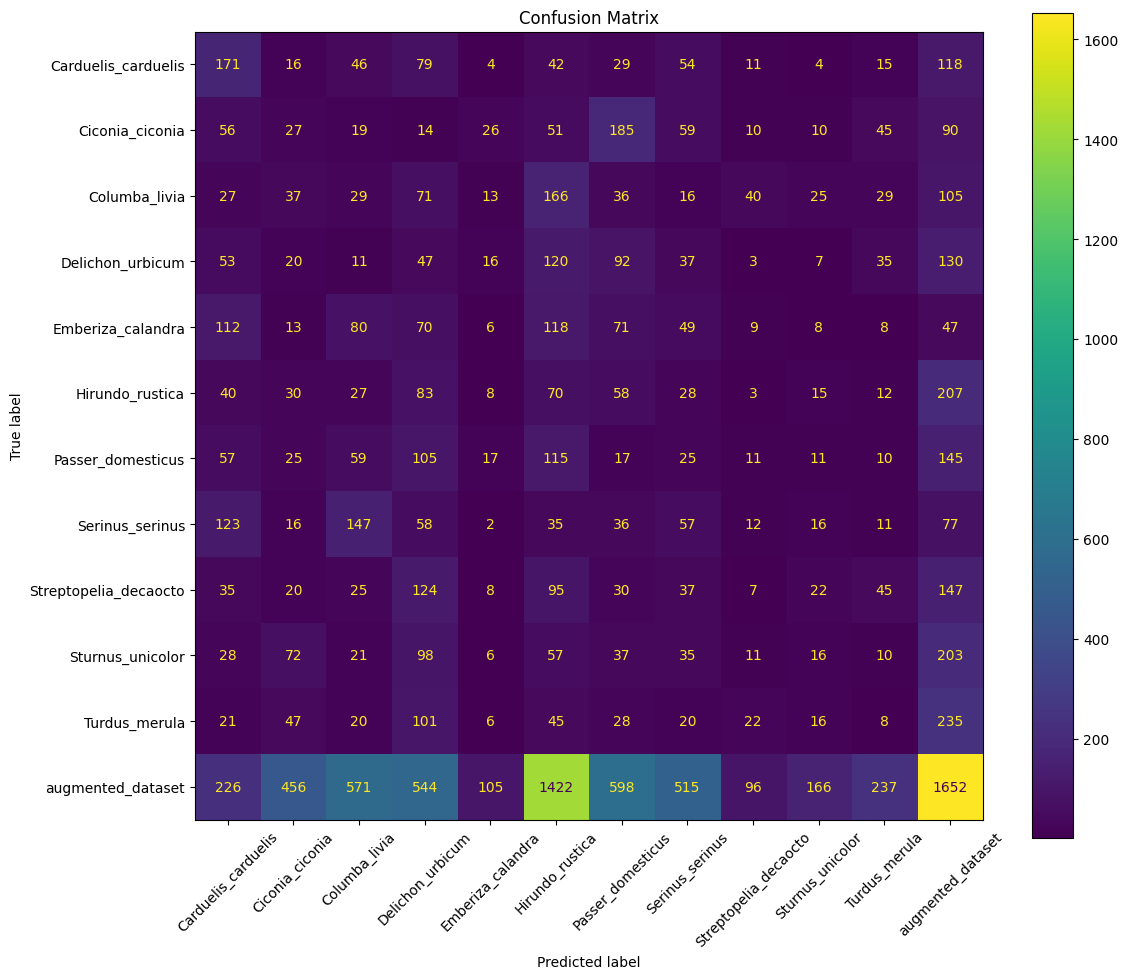


Sample Predictions:
Sample 10948: True = augmented_dataset, Predicted = Ciconia_ciconia
Sample 3807: True = Passer_domesticus, Predicted = augmented_dataset
Sample 10522: True = augmented_dataset, Predicted = Turdus_merula
Sample 10176: True = augmented_dataset, Predicted = Hirundo_rustica
Sample 847: True = Ciconia_ciconia, Predicted = Turdus_merula


In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from torchvision.datasets import ImageFolder


def show_classification_results(model, dataloader, class_names, device='cuda'):
    model, _ = getModel(model, nClasses=len(class_names))
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Optional: show a few correct and incorrect predictions
    print("\nSample Predictions:")
    for idx in np.random.choice(len(all_preds), size=5, replace=False):
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]
        print(f"Sample {idx}: True = {true_label}, Predicted = {pred_label}")

FINALMODEL = 'final_model_20250524.pth'
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_dataset_clean = ImageFolder(root=DATA_DIR, transform=transform)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False)
class_names = test_dataset_clean.classes
model = torch.load(os.path.join(MODEL_SAVE_DIR, FINALMODEL), weights_only=False)['best_params']['model_name']
show_classification_results(model, test_loader_clean, class_names, device='cuda')